In [1]:
!pip install -q tf-models-official==2.3.0

     |████████████████████████████████| 849kB 3.5MB/s 
     |████████████████████████████████| 358kB 17.8MB/s 
     |████████████████████████████████| 102kB 8.3MB/s 
     |████████████████████████████████| 1.1MB 13.9MB/s 
     |████████████████████████████████| 36.7MB 1.2MB/s 
     |████████████████████████████████| 174kB 49.1MB/s 


In [ ]:
import tensorflow as tf

import matplotlib.pyplot as plt
import os
import numpy as np

import tensorflow_hub as hub
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

from official.modeling import tf_utils
from official import nlp
from official.nlp import bert

# Load required submodules

import official.nlp.optimization
import official.nlp.bert.bert_models
import official.nlp.bert.configs
import official.nlp.bert.run_classifier
import official.nlp.bert.tokenization
import official.nlp.data.classifier_data_lib
import official.nlp.modeling.losses
import official.nlp.modeling.models
import official.nlp.modeling.networks

In [ ]:
#this directory contains the configuration, vocabulary, and a pre-trained checkpoint

gs_folder_bert = "gs://cloud-tpu-checkpoints/bert/keras_bert/uncased_L-12_H-768_A-12"
tf.io.gfile.listdir(gs_folder_bert)

['bert_config.json',
 'bert_model.ckpt.data-00000-of-00001',
 'bert_model.ckpt.index',
 'vocab.txt']

In [ ]:
hub_url_bert = "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2"

<h1>Preprocessing Dataset</h1>
We're now going to use the GLUE MPRC dataset from tfds, which it contains hand labeled data that checks if two sentences are semantically correct.

However, since this dataset is not set up, it cannot be fed into the BERT model. Thus, we're <b>doing the necessary preprocessing now</b>.

In [ ]:
glue, info = tfds.load(
    'glue/mrpc', with_info=True, batch_size = -1 #this loads the ENTIRE dataset, it's small, so it's ok
    )

/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Shuffling and writing examples to /root/tensorflow_datasets/glue/mrpc/1.0.0.incompleteRQQNNU/glue-train.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/glue/mrpc/1.0.0.incompleteRQQNNU/glue-validation.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/glue/mrpc/1.0.0.incompleteRQQNNU/glue-test.tfrecord
Dataset glue downloaded and prepared to /root/tensorflow_datasets/glue/mrpc/1.0.0. Subsequent calls will reuse this data.


In [ ]:
list(glue.keys())

['test', 'train', 'validation']

In [ ]:
#info describes the dataset and its features
info.features

FeaturesDict({
    'idx': tf.int32,
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    'sentence1': Text(shape=(), dtype=tf.string),
    'sentence2': Text(shape=(), dtype=tf.string),
})

In [ ]:
info.features['label'].names

['not_equivalent', 'equivalent']

In [ ]:
glue_train = glue['train']

for key, value in glue_train.items():
  print(f"{key:9s}: {value[0].numpy()}")

idx      : 1680
label    : 0
sentence1: b'The identical rovers will act as robotic geologists , searching for evidence of past water .'
sentence2: b'The rovers act as robotic geologists , moving on six wheels .'


<h1>Using the BERT Tokenizer</h1>

In [ ]:
#set up tokenizer to generate Tensorflow dataset
tokenizer = bert.tokenization.FullTokenizer(
    vocab_file = os.path.join(gs_folder_bert, "vocab.txt"),
    do_lower_case = True
)

print("Vocab size: ", len(tokenizer.vocab))

Vocab size:  30522


We will now try to tokenize a sentence

In [ ]:
tokens = tokenizer.tokenize("Hello TensorFlow!")
print(tokens)
ids = tokenizer.convert_tokens_to_ids(tokens)
print(ids)

['hello', 'tensor', '##flow', '!']
[7592, 23435, 12314, 999]


In [ ]:
tokenizer.convert_tokens_to_ids(['[CLS]', '[SEP]'])

[101, 102]

In [ ]:
def encode_sentence(s):
  tokens = list(tokenizer.tokenize(s.numpy()))
  tokens.append('[SEP]')
  return tokenizer.convert_tokens_to_ids(tokens)

sentence1 = tf.ragged.constant([
        encode_sentence(s) for s in glue_train['sentence1']                        
])
sentence2 = tf.ragged.constant([
        encode_sentence(s) for s in glue_train['sentence2']
])

In [ ]:
print("Sentence 1 shape: ", sentence1.shape.as_list())
print("Sentence 2 shape: ", sentence2.shape.as_list())

Sentence 1 shape:  [3668, None]
Sentence 2 shape:  [3668, None]


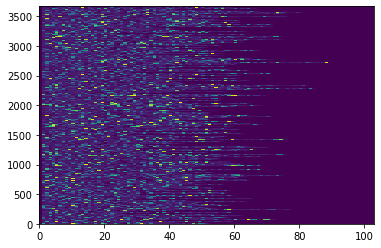

In [ ]:
cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*sentence1.shape[0]
input_word_ids = tf.concat([cls, sentence1, sentence2], axis=-1)
_ = plt.pcolormesh(input_word_ids.to_tensor())

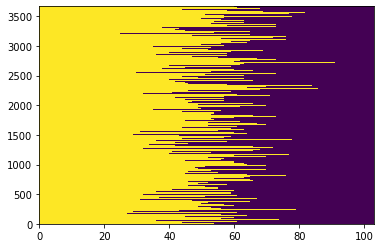

In [ ]:
input_mask = tf.ones_like(input_word_ids).to_tensor()

plt.pcolormesh(input_mask)

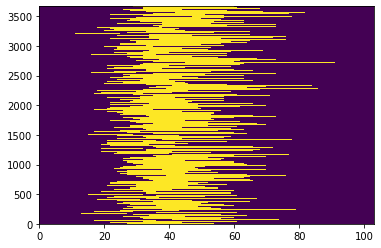

In [ ]:
type_cls = tf.zeros_like(cls)
type_s1 = tf.zeros_like(sentence1)
type_s2 = tf.ones_like(sentence2)
input_type_ids = tf.concat([type_cls, type_s1, type_s2], axis=-1).to_tensor()

plt.pcolormesh(input_type_ids)

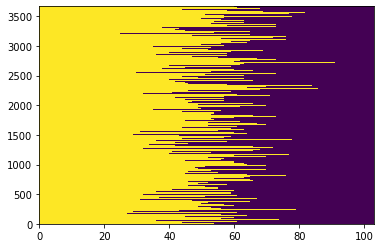

In [ ]:
input_mask = tf.ones_like(input_word_ids).to_tensor()
plt.pcolormesh(input_mask)

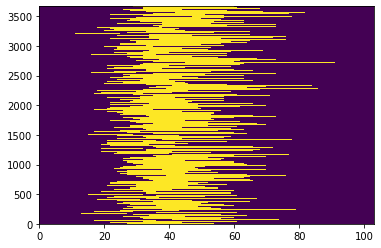

In [ ]:
type_cls = tf.zeros_like(cls)
type_s1 = tf.zeros_like(sentence1)
type_s2 = tf.ones_like(sentence2)
input_type_ids = tf.concat([type_cls, type_s1, type_s2], axis=-1).to_tensor()

plt.pcolormesh(input_type_ids)

In [ ]:
def encode_sentence(s, tokenizer):
   tokens = list(tokenizer.tokenize(s))
   tokens.append('[SEP]')
   return tokenizer.convert_tokens_to_ids(tokens)

def bert_encode(glue_dict, tokenizer):
  num_examples = len(glue_dict["sentence1"])
  
  sentence1 = tf.ragged.constant([
      encode_sentence(s, tokenizer)
      for s in np.array(glue_dict["sentence1"])])
  sentence2 = tf.ragged.constant([
      encode_sentence(s, tokenizer)
       for s in np.array(glue_dict["sentence2"])])

  cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*sentence1.shape[0]
  input_word_ids = tf.concat([cls, sentence1, sentence2], axis=-1)

  input_mask = tf.ones_like(input_word_ids).to_tensor()

  type_cls = tf.zeros_like(cls)
  type_s1 = tf.zeros_like(sentence1)
  type_s2 = tf.ones_like(sentence2)
  input_type_ids = tf.concat(
      [type_cls, type_s1, type_s2], axis=-1).to_tensor()

  inputs = {
      'input_word_ids': input_word_ids.to_tensor(),
      'input_mask': input_mask,
      'input_type_ids': input_type_ids}

  return inputs

In [ ]:
glue_train = bert_encode(glue['train'], tokenizer)
glue_train_labels = glue['train']['label']

glue_validation = bert_encode(glue['validation'], tokenizer)
glue_validation_labels = glue['validation']['label']

glue_test = bert_encode(glue['test'], tokenizer)
glue_test_labels  = glue['test']['label']

In [ ]:
for key, value in glue_train.items():
  print(f'{key:15s} shape: {value.shape}')

print(f'glue_train_labels: {glue_train_labels.shape}')

input_word_ids  shape: (3668, 103)
input_mask      shape: (3668, 103)
input_type_ids  shape: (3668, 103)
glue_train_labels: (3668,)


In [ ]:
import json

bert_config_file = os.path.join(gs_folder_bert, "bert_config.json")
config_dict = json.loads(tf.io.gfile.GFile(bert_config_file).read())

bert_config = bert.configs.BertConfig.from_dict(config_dict)

config_dict

{'attention_probs_dropout_prob': 0.1,
 'hidden_act': 'gelu',
 'hidden_dropout_prob': 0.1,
 'hidden_size': 768,
 'initializer_range': 0.02,
 'intermediate_size': 3072,
 'max_position_embeddings': 512,
 'num_attention_heads': 12,
 'num_hidden_layers': 12,
 'type_vocab_size': 2,
 'vocab_size': 30522}

In [ ]:
bert_classifier, bert_encoder = bert.bert_models.classifier_model(
    bert_config, num_labels=2
)

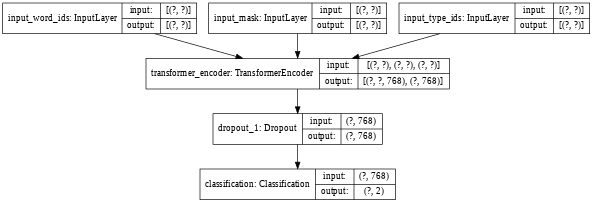

In [ ]:
tf.keras.utils.plot_model(bert_classifier, show_shapes=True, dpi=48)

In [ ]:
glue_batch = {key: val[:10] for key, val in glue_train.items()}

bert_classifier(
    glue_batch, training=True
).numpy()

array([[ 0.0759881 , -0.05212135],
       [ 0.26244354, -0.17950076],
       [ 0.37075433, -0.21583956],
       [ 0.03852636, -0.02761826],
       [ 0.01521903,  0.11818215],
       [ 0.18330434, -0.04836553],
       [ 0.05697027, -0.14668113],
       [ 0.17221715, -0.18030451],
       [ 0.14470358, -0.20289226],
       [ 0.04217424,  0.05962449]], dtype=float32)

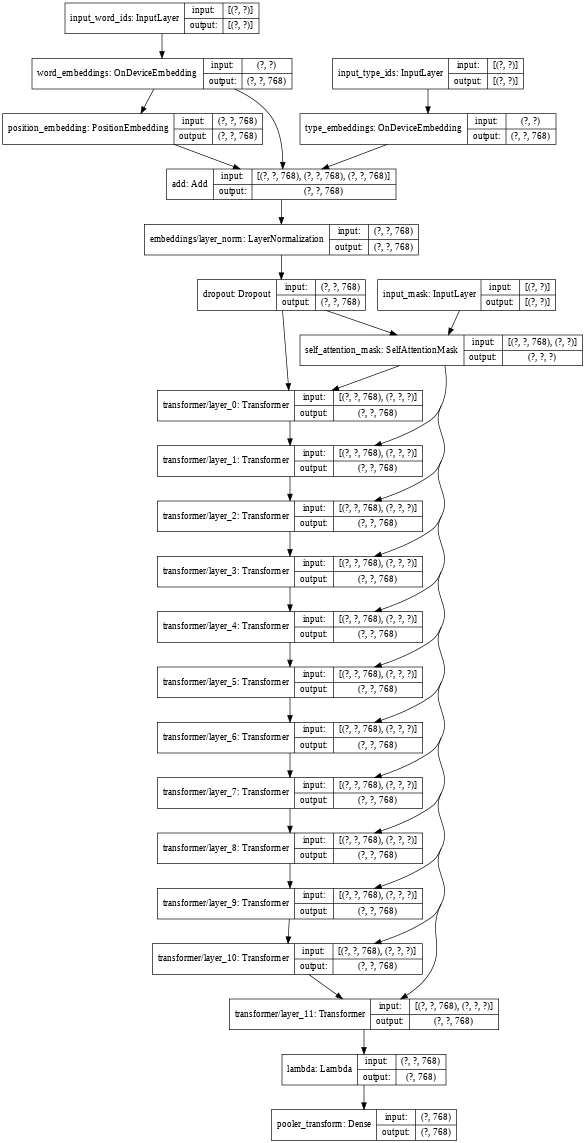

In [ ]:
tf.keras.utils.plot_model(bert_encoder, show_shapes=True, dpi=48)

In [ ]:
checkpoint = tf.train.Checkpoint(model=bert_encoder)
checkpoint.restore(
    os.path.join(gs_folder_bert, 'bert_model.ckpt')
).assert_consumed()

In [ ]:
#set up epochs and steps

epochs = 3
batch_size = 32
eval_batch_size = 32

train_data_size = len(glue_train_labels)
steps_per_epoch = int(train_data_size/batch_size)
num_train_steps = steps_per_epoch * epochs
warmup_steps = int(epochs * train_data_size * 0.1/batch_size)

#creates an optimizer with learning rate schedule
optimizer = nlp.optimization.create_optimizer(
    2e-5, num_train_steps=num_train_steps, num_warmup_steps=warmup_steps
)

In [ ]:
type(optimizer)

official.nlp.optimization.AdamWeightDecay

In [ ]:
metrics = [tf.keras.metrics.SparseCategoricalAccuracy('accuracy', dtype=tf.float32)]
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [ ]:
bert_classifier.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=metrics    
)

bert_classifier.fit(
    glue_train, glue_train_labels,
    validation_data=(glue_validation, glue_validation_labels),
    batch_size=32,
    epochs=epochs
)

Epoch 1/3
 58/115 [==============>...............] - ETA: 31:24 - loss: 0.7792 - accuracy: 0.5237

In [ ]:
my_examples = bert_encode(
    glue_dict = {
        'sentence1':[
            'The rain in Spain falls mainly on the plain.',
            'Look I fine tuned BERT.'],
        'sentence2':[
            'It mostly rains on the flat lands of Spain.',
            'Is it working? This does not match.']
    },
    tokenizer=tokenizer)

In [ ]:
result = bert_classifier(my_examples, training=False)

result = tf.argmax(result).numpy()
result

In [ ]:
export_dir = './saved_model'
tf.saved_model.save(bert_classifier, export_dir=export_dir)

In [ ]:
reloaded = tf.saved_model.load(export_dir)
reloaded_result = reloaded([my_examples['input_word_ids'],
                            my_examples['input_mask'],
                            my_examples['input_type_ids']], training=False)

original_result = bert_classifier(my_examples, training=False)

# The results are (nearly) identical:
print(original_result.numpy())
print()
print(reloaded_result.numpy())